In [1]:
import time
start_time = time.time()

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.001

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [5]:
# Loading the dataset
raw_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=False, transform=transforms.ToTensor())

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# 45000 for training, 5000 for validation, 10000 for testing
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = train_dataset.classes

In [6]:
# Pre-trained VGG16 model adapted to the dataset
def get_pretrained_vgg16(num_classes=10):
    model = torchvision.models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

In [7]:
model = get_pretrained_vgg16(num_classes=10).to(device)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    start = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            dataloader = dataloaders[phase]
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train" and scheduler is not None:
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            print(f"{phase} loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - start
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    model.load_state_dict(best_model_wts)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Training")
    plt.plot(val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("vgg16_train_val.png")
    plt.show()
    
    return model, (train_losses, val_losses, train_accs, val_accs)

Epoch 1/50
----------
train loss: 0.9797 accuracy: 0.6554
val loss: 0.6594 accuracy: 0.7730

Epoch 2/50
----------
train loss: 0.6171 accuracy: 0.7884
val loss: 0.5391 accuracy: 0.8142

Epoch 3/50
----------
train loss: 0.5192 accuracy: 0.8227
val loss: 0.4304 accuracy: 0.8542

Epoch 4/50
----------
train loss: 0.4685 accuracy: 0.8407
val loss: 0.4047 accuracy: 0.8628

Epoch 5/50
----------
train loss: 0.4210 accuracy: 0.8544
val loss: 0.3784 accuracy: 0.8744

Epoch 6/50
----------
train loss: 0.3836 accuracy: 0.8683
val loss: 0.3382 accuracy: 0.8866

Epoch 7/50
----------
train loss: 0.3587 accuracy: 0.8757
val loss: 0.3081 accuracy: 0.8922

Epoch 8/50
----------
train loss: 0.3312 accuracy: 0.8842
val loss: 0.3272 accuracy: 0.8856

Epoch 9/50
----------
train loss: 0.3174 accuracy: 0.8913
val loss: 0.2676 accuracy: 0.9088

Epoch 10/50
----------
train loss: 0.2956 accuracy: 0.8982
val loss: 0.2574 accuracy: 0.9068

Epoch 11/50
----------
train loss: 0.2814 accuracy: 0.9020
val loss: 

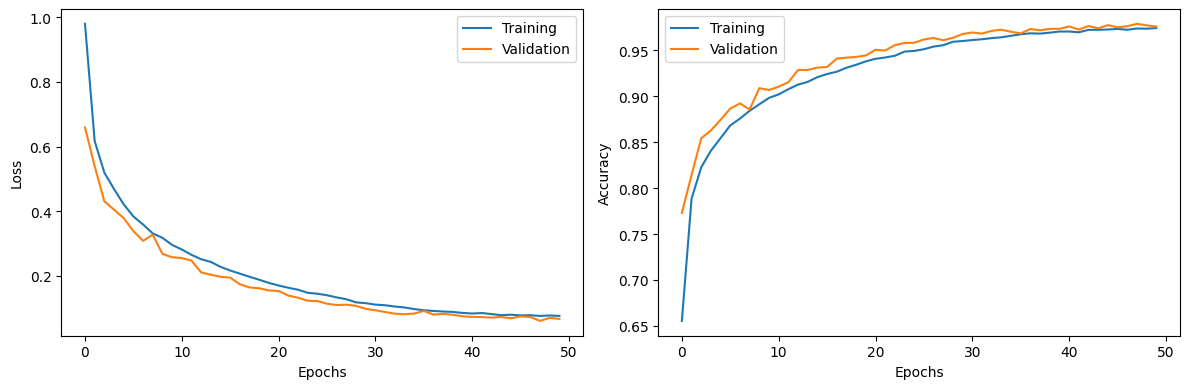

In [9]:
# Train or load the model accordingly
if os.path.exists("vgg16_cifar10.pth"):
    model.load_state_dict(torch.load("vgg16_cifar10.pth"))
    if os.path.exists("vgg16_training_history.npz"):
        data = np.load("vgg16_training_history.npz")
        train_losses = data["train_losses"]
        val_losses = data["val_losses"]
        train_accs = data["train_accs"]
        val_accs = data["val_accs"]
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Training")
        plt.plot(val_losses, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label="Training")
        plt.plot(val_accs, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.savefig("vgg16_cifar10_training.png")
        plt.show()
else:
    model, history = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, scheduler, num_epochs)
    torch.save(model.state_dict(), "vgg16_cifar10.pth")
    np.savez("vgg16_training_history.npz", train_losses=history[0], val_losses=history[1], train_accs=history[2], val_accs=history[3])

In [10]:
# Test the model
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            c = (predicted == targets).squeeze()
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100.*correct/total:.2f}%")
    
    for i in range(10):
        print(f"Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

In [11]:
test(model, test_loader)

Test Loss: 0.3760, Accuracy: 90.46%
Accuracy of airplane: 92.30%
Accuracy of automobile: 96.20%
Accuracy of bird: 88.70%
Accuracy of cat: 78.80%
Accuracy of deer: 90.50%
Accuracy of dog: 83.90%
Accuracy of frog: 93.60%
Accuracy of horse: 91.70%
Accuracy of ship: 95.00%
Accuracy of truck: 93.90%


<Figure size 1000x800 with 0 Axes>

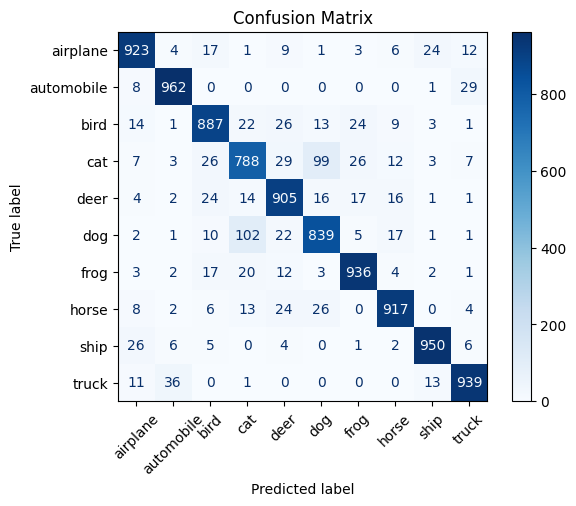

In [12]:
# Plot confusion matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.savefig("vgg16_confusion_matrix.png")
plt.show()

C:\Users\pmigu\AppData\Local\Temp\ipykernel_2344\1429673711.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("nipy_spectral", n_classes)


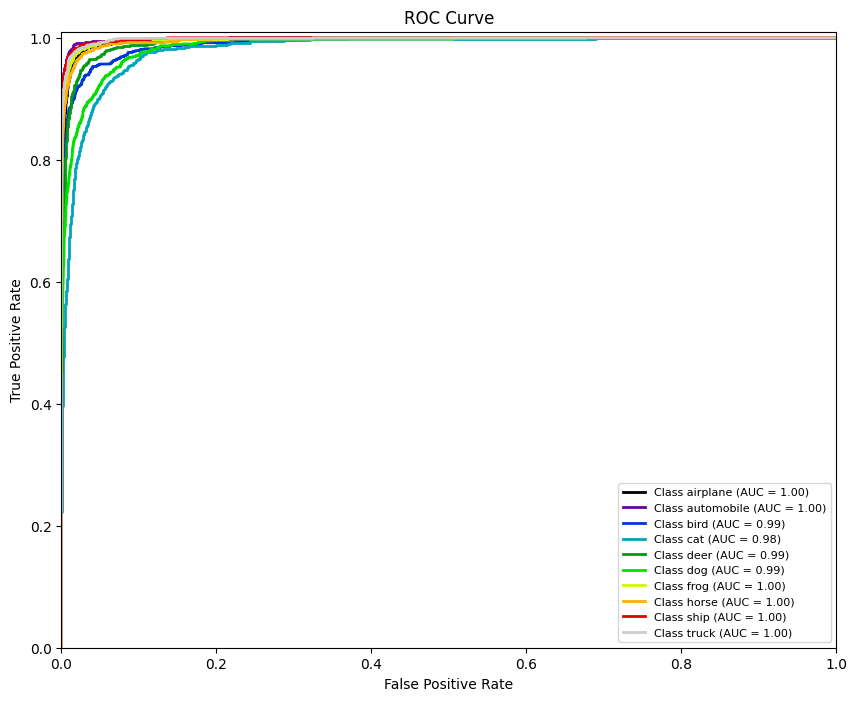

In [13]:
# Plot ROC curve
n_classes = 10
all_probs = []
all_targets_bin = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_targets_bin.extend(label_binarize(targets.cpu().numpy(), classes=range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve([row[i] for row in all_targets_bin], [row[i] for row in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("nipy_spectral", n_classes)

for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        color=colors(i),
        lw=2,
        label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right", fontsize=8)
plt.savefig("vgg16_roc_curve.png")
plt.show()

In [14]:
# Set up Grad-CAM and plot
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

In [15]:
target_layer = model.features[29]  # Last convolutional layer in VGG16
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

In [16]:
image_tensor, label = test_dataset[321] # Select image of choice
input_tensor = image_tensor.unsqueeze(0).to(device)

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

pooled_gradients = gradients.mean(dim=[0, 2, 3])
activation = activations[0]

for i in range(activation.shape[0]):
    activation[i] *= pooled_gradients[i]

heatmap = activation.sum(dim=0).cpu()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

d:\Python\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\pmigu\AppData\Local\Temp\ipykernel_2344\2970946255.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


In [17]:
unnorm = transforms.Normalize(
    mean=[-m/s for m, s in zip((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))],
    std=[1/s for s in (0.2470, 0.2435, 0.2616)]
)
image_np = unnorm(image_tensor).permute(1, 2, 0).cpu().numpy()
image_np = np.clip(image_np, 0, 1)

heatmap_resized = cv2.resize(heatmap.numpy(), (32, 32))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

overlayed = 0.4 * heatmap_color + 0.6 * image_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08235293626785278..1.0000000238418578].


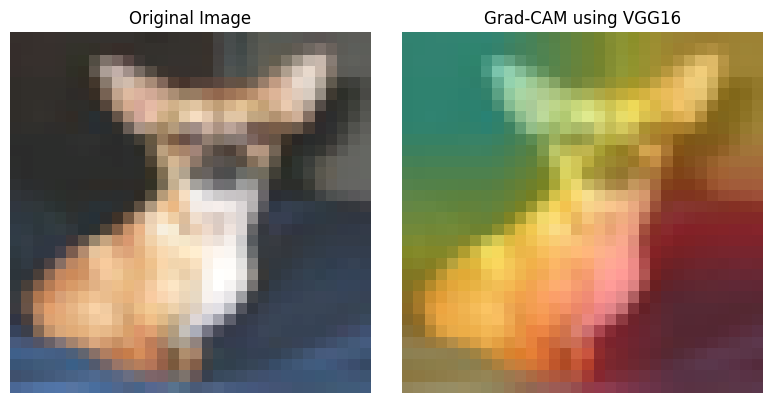

In [18]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlayed)
plt.title("Grad-CAM using VGG16")
plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
# Compute metrics
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
f1 = f1_score(all_targets, all_preds, average="weighted")

In [20]:
end_time = time.time()
total_time = end_time - start_time

In [24]:
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")
print(f"Computation Time: {total_time:.2f}s")

Precision: 90.43%
Recall: 90.46%
F1-score: 90.44%
Computation Time: 3412.90s


# Dataset
Informações do dataset, não relacionado com o modelo

C:\Users\pmigu\AppData\Local\Temp\ipykernel_2344\2214479478.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=class_counts, palette="Set2")


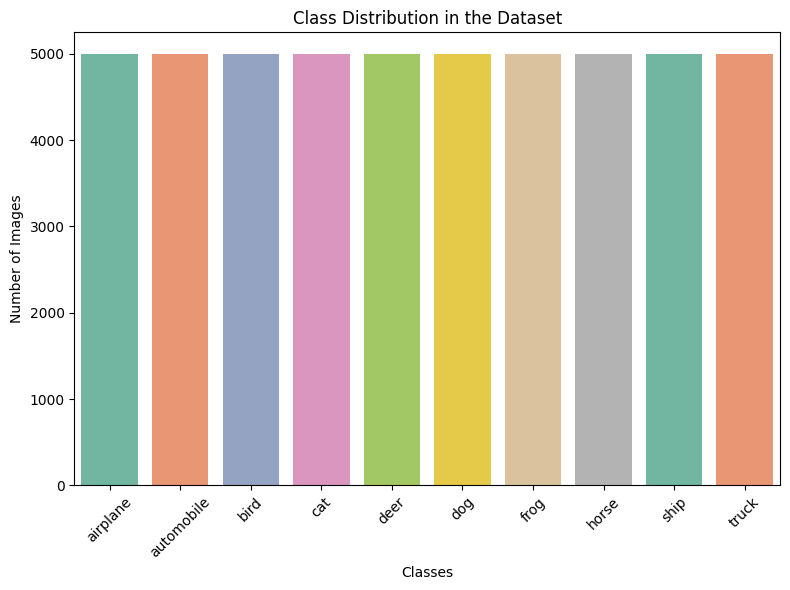

In [22]:
import seaborn as sns

class_counts = np.zeros(10)
for _, label in train_loader:
    for l in label:
        class_counts[l] += 1

plt.figure(figsize=(8, 6))
sns.barplot(x=classes, y=class_counts, palette="Set2")
plt.title("Class Distribution in the Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pmigu\AppData\Local\Temp\ipykernel_2344\1552946211.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(means.T, labels=classes)


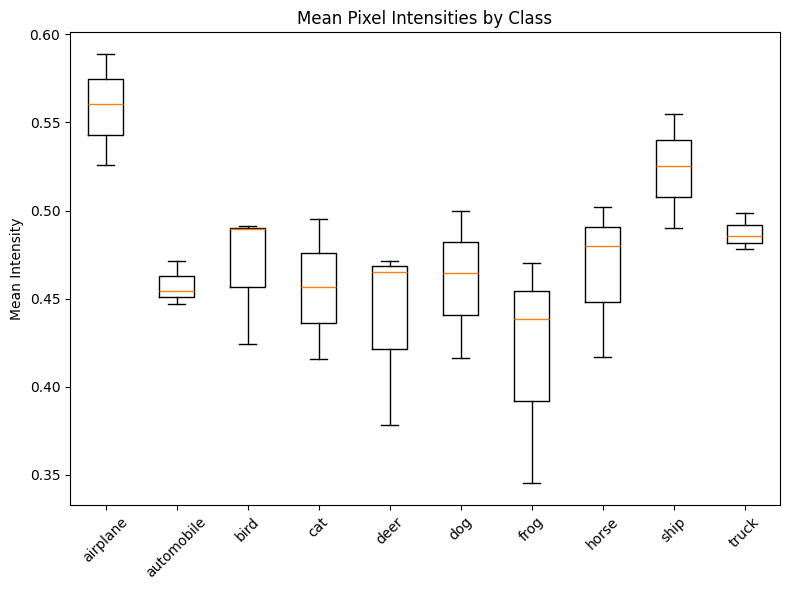

In [ ]:
means = np.zeros((10, 3))

for i in range(10):
    class_indices = [idx for idx, label in enumerate(raw_dataset.targets) if label == i]
    
    class_images = [raw_dataset[idx][0] for idx in class_indices]
    class_images = torch.stack(class_images)
    
    means[i] = torch.mean(class_images, dim=(0, 2, 3)).numpy()

fig, ax = plt.subplots(figsize=(8, 6))

ax.boxplot(means.T, labels=classes)
ax.set_title("Mean Pixel Intensities by Class")
ax.set_ylabel("Mean Intensity")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()